In [ ]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 or latexr

torch.__version__

#SEt-up device-agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive # Mount my google drive diretory
drive.mount("/content/gdrive",force_remount=True)
import os # Change directory to CS284 folder in google drive
os.chdir("gdrive/MyDrive/Pruning_Study")

Mounted at /content/gdrive


##Dataset download an preparation

Loads ImageNette Dataset

In [ ]:
!pip install Pillow

In [ ]:
!ls

 CIFAR10
 coco
 Imagenette
 Imagewoof
 ModeL_Pruning_Experiment_07052024.ipynb
 ModeL_Pruning_Experiment_07052024_smallerprune.ipynb
' ModeL_Pruning_Experiment_07072024.ipynb'
 ModeL_Pruning_Experiment_ImageNette07142024.ipynb
' ModeL_Pruning_Experiment_ImageNette07202024.ipynb'
 ModeL_Pruning_Experiment_ImageWoof07202024.ipynb
 models


In [ ]:
#train_csv = 'Imagenette/imagenette2/train.csv'
#test_csv = 'Imagenette/imagenette2/test.csv'

# Root directory containing the images
root_dir = 'Imagenette/imagenette2'
train_dir='Imagenette/train_resized'
test_dir='Imagenette/val_resized'


from torchvision import datasets
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset=datasets.ImageFolder(root=train_dir,transform=transform_train,#transform for data
                                target_transform=None)# transform for label/target

testset=datasets.ImageFolder(root=test_dir,transform=transform_test,#transform for data
                                target_transform=None)# transform for label/target

trainset,testset

(Dataset ImageFolder
     Number of datapoints: 9469
     Root location: Imagenette/train_resized
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ),
 Dataset ImageFolder
     Number of datapoints: 3925
     Root location: Imagenette/val_resized
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ))

In [ ]:
class_names=trainset.classes
class_dict=trainset.class_to_idx
class_dict

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

In [ ]:
img,label=trainset[0][0],trainset[0][1]
print(f"Image tensor: \n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatpe: {type(label)}")

Image tensor: 
 tensor([[[ 0.8961,  1.1015,  0.9303,  ...,  0.1597,  0.6906,  1.0502],
         [ 0.9646,  0.8104,  0.7077,  ...,  0.9132,  0.9303,  1.1187],
         [ 1.0331,  1.0673,  0.8447,  ...,  0.2282,  0.2796,  0.8961],
         ...,
         [ 0.0912,  0.1939, -0.2856,  ..., -0.0801, -0.0801, -0.5082],
         [ 0.0741,  1.1529,  0.4851,  ..., -0.3198, -0.1486, -0.2342],
         [ 0.0398,  0.9474,  1.1015,  ..., -0.6109, -0.5424, -0.4739]],

        [[ 1.1506,  1.3606,  1.2031,  ..., -0.0224,  0.6954,  1.1331],
         [ 1.2206,  1.0630,  0.9755,  ...,  0.6429,  0.8704,  1.1681],
         [ 1.2906,  1.3256,  1.1331,  ..., -0.0749,  0.1352,  0.8704],
         ...,
         [ 0.4503,  0.5553, -0.0049,  ...,  0.5203,  0.5378,  0.1176],
         [ 0.4328,  1.5357,  0.8004,  ...,  0.2402,  0.4153,  0.3277],
         [ 0.3978,  1.2906,  1.4657,  ..., -0.0399, -0.0049,  0.0476]],

        [[ 1.3328,  1.5071,  1.3154,  ..., -0.3404,  0.4091,  0.9319],
         [ 1.4025,  1.2282,  

Original Shapes:torch.Size([3, 224, 224])->C,H,W
Original Shapes:torch.Size([224, 224, 3])->H,W,C


Text(0.5, 1.0, 'n01440764')

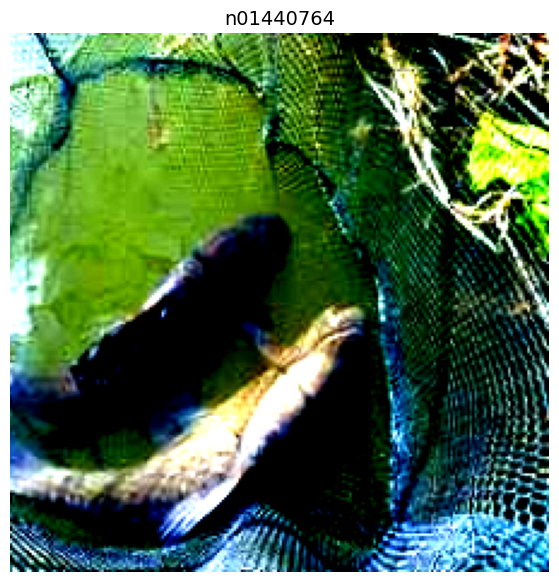

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_permute=img.permute(1,2,0)
print(f"Original Shapes:{img.shape}->C,H,W")
print(f"Original Shapes:{img_permute.shape}->H,W,C")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

In [ ]:
#Batch size and dataloader setting


batch_size = 64
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False,num_workers=4)

In [ ]:
len(train_dataloader),len(test_dataloader)

(148, 62)

In [ ]:
img,label=next(iter(test_dataloader))

img.shape,label[0]

(torch.Size([64, 3, 224, 224]), tensor(0))

## Full Model

MobileNet V1 implementation is based from here: https://medium.com/@karuneshu21/implement-mobilenet-v1-in-pytorch-fd03a6618321

The implementation is modified to only have 10 classes as we are only using CIFAR-10 Dataset

In [ ]:
import torch
# all nn libraries nn.layer, convs and loss functions

import torch.nn as nn
# Display Image

from IPython.display import Image

# visualisation
!pip install torchview
import torchvision
from torchview import draw_graph

# !pip install transformers
#from transformers import MobileNetV1Config, MobileNetV1Model

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#Depthwise example

import torch
import torch.nn as nn

# Define a simple depthwise convolutional layer
class DepthwiseConv2d(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels)

    def forward(self, x):
        x = self.depthwise(x)
        return x

# Example usage
# Create a random input tensor
input_tensor = torch.randn(1, 3, 32, 32)  # (batch_size, channels, height, width)

# Define a depthwise convolutional layer
depthwise_conv = DepthwiseConv2d(in_channels=3, kernel_size=3, stride=1, padding=1)

# Apply the depthwise convolution to the input tensor
output_tensor = depthwise_conv(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output_tensor.shape)

Output tensor shape: torch.Size([1, 3, 32, 32])


In [ ]:
import torch
import torch.nn as nn

# Define a simple pointwise convolutional layer
class PointwiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super(PointwiseConv2d, self).__init__()
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.pointwise(x)
        return x

# Example usage
# Create a random input tensor
input_tensor = torch.randn(1, 3, 32, 32)  # (batch_size, channels, height, width)

# Define a pointwise convolutional layer
pointwise_conv = PointwiseConv2d(in_channels=3, out_channels=64)

# Apply the pointwise convolution to the input tensor
output_tensor = pointwise_conv(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output_tensor.shape)

Output tensor shape: torch.Size([1, 64, 32, 32])


In [ ]:
class DepthWiseSeperable(nn.Module):

    def __init__(self, in_channels , out_channels , stride ):
        """
        DepthWiseSeperable block of MobileNet which performs the following operations:
        (a) depthwise convolution by applying a separate filter for each channel
        (b) pointwise convolutions are applied which combine the filtered result by implementing 1 × 1 convolution

            Note:
                1. groups = in_channels used for depthwise convolution
                2. in_channels and out_channels are same for depthwise convolution
                3. bias = False due to the usage of BatchNorm
                4. To generate same height and width of output feature map as the input feature map, following should be padding for
                    * 1x1 conv : p=0
                    * 3x3 conv : p=1
                    * 5x5 conv : p=2


        Args:
          in_channels (int) : number of input channels
          out_channels (int) : number of output channels
          stride (int) : stride used for depthwise convolution

        Attributes:
            Depthwise seperable convolutional block

        """

        super(DepthWiseSeperable,self).__init__()

        # groups used here
        self.depthwise = nn.Conv2d(in_channels = in_channels , out_channels = in_channels , stride = stride , padding = 1, kernel_size = 3 , groups=in_channels , bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , stride = 1 , padding = 0, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self,x):

        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


def test_DepthWiseSeperable():
    x = torch.randn(1,32,112,112)
    model = DepthWiseSeperable(32,64,2)
    print(model(x).shape)

    return model


#model = test_DepthWiseSeperable()
#architecture = 'DepthWiseSeperable'
#model_graph = draw_graph(model, input_size=(1,32,112,112), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
#model_graph.visual_graph

# output
"""
torch.Size([1, 64, 56, 56])
"""

'\ntorch.Size([1, 64, 56, 56])\n'

In [ ]:
test=img
test.shape

torch.Size([64, 3, 224, 224])

In [ ]:
class MobileNetV1(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 512, 1)
        self.features13 = DepthWiseSeperable(512, 1024, 2)
        self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
        x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_big=MobileNetV1()
test_input=test
test_input.shape
test_model=model_big(test_input)
test_model.shape
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  3217226


In [ ]:
# Import time it for training time checking and printing of total time
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

def print_test_time(start:float,end:float,device:torch.device=None):
  total_time=end-start
  print(f"Test time on {device}: {total_time:.3f} seconds")
  return total_time

# Function made for accuracy checking
def accuracy_fn(y_target,y_pred):

    correct = (y_target==y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
#Training from scratch
from torch.optim.lr_scheduler import CosineAnnealingLR

device="cuda" if torch.cuda.is_available() else "cpu" #device
loss_fn=nn.CrossEntropyLoss()#Loss Function

model_big=MobileNetV1()
optimizer1=torch.optim.Adam(params=model_big.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
sigmoid=nn.Sigmoid()

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Training and Testing Function
def training(model:torch.nn.Module,data_loader:DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer, accuracy_fn,device:torch.device=device):
  train_loss,train_acc=0,0
  model.to(device)
  model.train()

  for batch,(X,y) in enumerate(data_loader):
    X,y=X.float().to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_loss=train_loss+loss

    train_acc=train_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  lr_scheduler.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"Train Loss:{train_loss:5f}|Train Acc:{train_acc:5f}%")
  return train_loss,train_acc


def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

In [ ]:
'''
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_big_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}")
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_big,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_big,loss_fn=loss_fn,accuracy_fn=accuracy_fn)


  if (test_acc>best_acc):
    best_acc=test_acc
    model_big.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_big.state_dict(),f=model_save_path)
    print(f"New best test acc is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_big_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_big.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_big.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)
'''

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:0
Train Loss:1.759284|Train Acc:37.836453%
Test loss: 1.58280 | Test accuracy: 46.43%

New best test acc is 46.434571812596005. Model Saved
Epoch:1
Train Loss:1.301645|Train Acc:55.514960%
Test loss: 1.41543 | Test accuracy: 53.69%

New best test acc is 53.6902361751152. Model Saved
Epoch:2
Train Loss:1.103018|Train Acc:63.325210%
Test loss: 1.33088 | Test accuracy: 56.74%

New best test acc is 56.740831413210444. Model Saved
Epoch:3
Train Loss:0.965262|Train Acc:68.057017%
Test loss: 1.15464 | Test accuracy: 62.74%

New best test acc is 62.73881528417819. Model Saved
Epoch:4
Train Loss:0.830672|Train Acc:72.714922%
Test loss: 1.19448 | Test accuracy: 61.86%

Epoch:5
Train Loss:0.731839|Train Acc:76.482367%
Test loss: 0.95781 | Test accuracy: 68.24%

New best test acc is 68.23516705069125. Model Saved
Epoch:6
Train Loss:0.661411|Train Acc:78.771773%
Test loss: 1.07163 | Test accuracy: 65.79%

Epoch:7
Train Loss:0.587004|Train Acc:80.872702%
Test loss: 0.95855 | Test accuracy: 69.

4194.514351535

In [ ]:
#Loading trained model
def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

# This is when conitnuing training of a previously saved model
from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_big_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_big=MobileNetV1()
model_big.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_big.parameters(),lr=0.0005,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
#start_timer=timer()
#test_loss,test_acc=testing(data_loader=test_dataloader,model=model_big,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

#best_loss=test_loss
#best_loss
#end_timer=timer()
#print_test_time(start=start_timer,end=end_timer,device=device)

In [ ]:
import torch
import torch.nn as nn

def get_scaling_factors(network):
    scaling_factors = []
    for module in network.modules():
        if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
            scaling_factors.append(module.weight)
    return scaling_factors
scaling_factors=get_scaling_factors(model_big)
scaling_factors[2],max(scaling_factors[2]),min(scaling_factors[2])


(Parameter containing:
 tensor([0.2458, 0.2213, 0.2585, 0.2262, 0.2792, 0.4111, 0.2575, 0.3932, 0.2876,
         0.3102, 0.2036, 0.1822, 0.3141, 0.3086, 0.1820, 0.1972, 0.2556, 0.3161,
         0.3212, 0.1934, 0.2139, 0.2200, 0.2564, 0.1954, 0.2481, 0.2418, 0.2147,
         0.3075, 0.2214, 0.2501, 0.2048, 0.2103, 0.2296, 0.3739, 0.1799, 0.2410,
         0.1753, 0.2010, 0.2503, 0.1916, 0.3030, 0.3142, 0.1975, 0.2218, 0.2890,
         0.3638, 0.3729, 0.2022, 0.3301, 0.3495, 0.2307, 0.2876, 0.2736, 0.1855,
         0.3214, 0.2618, 0.2922, 0.3276, 0.2760, 0.2608, 0.2206, 0.3415, 0.2829,
         0.2018], device='cuda:0', requires_grad=True),
 tensor(0.4111, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1753, device='cuda:0', grad_fn=<UnbindBackward0>))

## Pruned seven blocks

The Network is pruned. 7 blocks are removed and are replaced with 2 smaller blocks. Values initialzied from tvalues of the original network

In [ ]:
class MobileNetV1_prunedblock6(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock6, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 64, 1)
        self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock6()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  310794


In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
#Checking number of parameters of pruned network
summary(model_small, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1_prunedblock6                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

In [ ]:
#Checking number of parameters of pruned network
summary(model_big, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1                              [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

Pruned Network only have ~310k parameters while the original network have 3.2M parameters. Step below copies the weights of the original network on the Pruned Network

In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock6()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_big.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.846623|Train Acc:42.467532%
Test loss: 1.61564 | Test accuracy: 54.12%

Epoch:0
New best test loss is 54.124663978494624. Model Saved
Train Loss:1.361685|Train Acc:65.615135%
Test loss: 1.28149 | Test accuracy: 63.09%

Epoch:1
New best test loss is 63.09283794162826. Model Saved
Train Loss:1.029959|Train Acc:73.873124%
Test loss: 0.96627 | Test accuracy: 72.07%

Epoch:2
New best test loss is 72.06581221198157. Model Saved
Train Loss:0.814953|Train Acc:78.626045%
Test loss: 0.91678 | Test accuracy: 72.95%

Epoch:3
New best test loss is 72.9502688172043. Model Saved
Train Loss:0.674544|Train Acc:82.163304%
Test loss: 0.79545 | Test accuracy: 76.30%

Epoch:4
New best test loss is 76.2996831797235. Model Saved
Train Loss:0.565445|Train Acc:84.519170%
Test loss: 0.97252 | Test accuracy: 68.26%

Epoch:5
Train Loss:0.476672|Train Acc:87.632574%
Test loss: 0.78034 | Test accuracy: 75.47%

Epoch:6
Train Loss:0.422453|Train Acc:89.015597%
Test loss: 0.79212 | Test accuracy: 74.97%



1396.924915345

In [ ]:
def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

# This is when conitnuing training of a previously saved model
from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock6()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
best_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

Test loss: 0.67918 | Test accuracy: 81.15%

Test time on cuda: 7.814 seconds


7.813538612999764

##Train small network from Random initialization

Trained the pruned network without copying initialization from the original network. The pruned network is trained with random values initialized.

In [ ]:
test=img
test.shape
model_small_random=MobileNetV1_prunedblock6()
test_input=test
test_input.shape
test_model=model_small_random(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small_random.parameters())
print("Total number of parameters: ", total_params)

loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small_random.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

Total number of parameters:  310794


In [ ]:
summary(model_small_random, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1_prunedblock6                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_random_ImageNette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small_random,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small_random,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small_random_ImageNette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.983847|Train Acc:33.734977%
Test loss: 1.78942 | Test accuracy: 41.87%

Epoch:0
New best test loss is 41.87307987711213. Model Saved
Train Loss:1.576894|Train Acc:51.632421%
Test loss: 1.50405 | Test accuracy: 51.55%

Epoch:1
New best test loss is 51.55289938556068. Model Saved
Train Loss:1.295612|Train Acc:61.453949%
Test loss: 1.28241 | Test accuracy: 60.95%

Epoch:2
New best test loss is 60.954301075268816. Model Saved
Train Loss:1.077486|Train Acc:68.021191%
Test loss: 1.12570 | Test accuracy: 64.56%

Epoch:3
New best test loss is 64.55573156682028. Model Saved
Train Loss:0.909517|Train Acc:73.722205%
Test loss: 1.01243 | Test accuracy: 67.53%

Epoch:4
New best test loss is 67.52952188940091. Model Saved
Train Loss:0.773944|Train Acc:77.359153%
Test loss: 1.02933 | Test accuracy: 66.47%

Epoch:5
Train Loss:0.655770|Train Acc:81.601164%
Test loss: 0.95258 | Test accuracy: 67.93%

Epoch:6
New best test loss is 67.93154761904762. Model Saved
Train Loss:0.581152|Train Acc:

1395.782438624

# Pruned two blocks

2 blocks replaced with 2 smaller

In [ ]:
class MobileNetV1_prunedblock1(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock1, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 512, 1)
        self.features13 = DepthWiseSeperable(512, 64, 2)
        self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
        x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock1()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1654794


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock1()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()
features8_parameters = model_big.features8.state_dict()
features9_parameters = model_big.features9.state_dict()
features10_parameters = model_big.features10.state_dict()
features11_parameters = model_big.features11.state_dict()
features12_parameters = model_big.features12.state_dict()



model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
model_small.features8.load_state_dict(features8_parameters)
model_small.features9.load_state_dict(features9_parameters)
model_small.features10.load_state_dict(features10_parameters)
model_small.features11.load_state_dict(features11_parameters)
model_small.features12.load_state_dict(features12_parameters)

for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small1_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small1_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.363174|Train Acc:75.459335%
Test loss: 1.18154 | Test accuracy: 70.10%

Epoch:0
New best test loss is 70.10008640552995. Model Saved
Train Loss:0.698270|Train Acc:87.199200%
Test loss: 0.87968 | Test accuracy: 74.39%

Epoch:1
New best test loss is 74.3879608294931. Model Saved
Train Loss:0.461438|Train Acc:90.063379%
Test loss: 0.88530 | Test accuracy: 72.87%

Epoch:2
Train Loss:0.368963|Train Acc:91.044182%
Test loss: 0.84942 | Test accuracy: 74.13%

Epoch:3
Train Loss:0.287095|Train Acc:92.637835%
Test loss: 0.85422 | Test accuracy: 73.78%

Epoch:4
Train Loss:0.252447|Train Acc:93.514102%
Test loss: 0.90965 | Test accuracy: 73.48%

Epoch:5
Train Loss:0.225208|Train Acc:93.832383%
Test loss: 0.79873 | Test accuracy: 75.72%

Epoch:6
New best test loss is 75.72244623655915. Model Saved
Train Loss:0.214016|Train Acc:94.115876%
Test loss: 0.97108 | Test accuracy: 71.49%

Epoch:7
Train Loss:0.203342|Train Acc:94.413041%
Test loss: 0.85012 | Test accuracy: 74.84%

Epoch:8
Train

4265.929441762

# Pruned three blocks

In [ ]:
class MobileNetV1_prunedblock2(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock2, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 64, 1)
        self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock2()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1385994


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock2()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()
features8_parameters = model_big.features8.state_dict()
features9_parameters = model_big.features9.state_dict()
features10_parameters = model_big.features10.state_dict()
features11_parameters = model_big.features11.state_dict()




model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
model_small.features8.load_state_dict(features8_parameters)
model_small.features9.load_state_dict(features9_parameters)
model_small.features10.load_state_dict(features10_parameters)
model_small.features11.load_state_dict(features11_parameters)


for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small2_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small2_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.553508|Train Acc:63.118735%
Test loss: 1.28624 | Test accuracy: 67.93%

Epoch:0
New best test loss is 67.93274769585253. Model Saved
Train Loss:0.873694|Train Acc:82.111556%
Test loss: 0.93153 | Test accuracy: 73.86%

Epoch:1
New best test loss is 73.85512672811059. Model Saved
Train Loss:0.599887|Train Acc:86.027325%
Test loss: 0.84598 | Test accuracy: 75.29%

Epoch:2
New best test loss is 75.29281874039938. Model Saved
Train Loss:0.460074|Train Acc:88.719470%
Test loss: 0.87545 | Test accuracy: 73.86%

Epoch:3
Train Loss:0.360033|Train Acc:91.063739%
Test loss: 0.98212 | Test accuracy: 69.62%

Epoch:4
Train Loss:0.303915|Train Acc:92.447801%
Test loss: 0.75094 | Test accuracy: 77.06%

Epoch:5
New best test loss is 77.05693164362519. Model Saved
Train Loss:0.262478|Train Acc:93.052690%
Test loss: 0.75176 | Test accuracy: 76.91%

Epoch:6
Train Loss:0.229522|Train Acc:93.747923%
Test loss: 0.79083 | Test accuracy: 75.82%

Epoch:7
Train Loss:0.191954|Train Acc:94.918760%
Tes

1427.4997156709996

# Pruned four blocks

5 blocks replaced with 2 smaller

In [ ]:
class MobileNetV1_prunedblock3(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock3, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 64, 1)
        self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock3()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1117194


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock3()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()
features8_parameters = model_big.features8.state_dict()
features9_parameters = model_big.features9.state_dict()
features10_parameters = model_big.features10.state_dict()





model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
model_small.features8.load_state_dict(features8_parameters)
model_small.features9.load_state_dict(features9_parameters)
model_small.features10.load_state_dict(features10_parameters)



for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small3_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small3_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.554838|Train Acc:63.306692%
Test loss: 1.32530 | Test accuracy: 65.61%

Epoch:0
New best test loss is 65.61419930875576. Model Saved
Train Loss:0.957585|Train Acc:78.307246%
Test loss: 0.98451 | Test accuracy: 71.89%

Epoch:1
New best test loss is 71.8906009984639. Model Saved
Train Loss:0.670270|Train Acc:83.386409%
Test loss: 0.93396 | Test accuracy: 71.74%

Epoch:2
Train Loss:0.513286|Train Acc:86.757345%
Test loss: 0.91114 | Test accuracy: 71.51%

Epoch:3
Train Loss:0.412459|Train Acc:89.363993%
Test loss: 0.80564 | Test accuracy: 74.71%

Epoch:4
New best test loss is 74.71198156682027. Model Saved
Train Loss:0.354587|Train Acc:90.821437%
Test loss: 0.85147 | Test accuracy: 73.75%

Epoch:5
Train Loss:0.302231|Train Acc:91.929968%
Test loss: 0.83473 | Test accuracy: 73.83%

Epoch:6
Train Loss:0.238466|Train Acc:93.821825%
Test loss: 0.79239 | Test accuracy: 75.55%

Epoch:7
New best test loss is 75.54843509984639. Model Saved
Train Loss:0.233565|Train Acc:93.546813%
Test

1423.936682308

# Pruned fiveblocks

5 blocks replaced with 2 smaller

In [ ]:
class MobileNetV1_prunedblock4(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock4, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 64, 1)
        self.features11 = DepthWiseSeperable(64, 32, 1)
       # self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
       # x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock4()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  848394


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock4()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()
features8_parameters = model_big.features8.state_dict()
features9_parameters = model_big.features9.state_dict()






model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
model_small.features8.load_state_dict(features8_parameters)
model_small.features9.load_state_dict(features9_parameters)




for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small4_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small4_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.666683|Train Acc:57.622120%
Test loss: 1.42270 | Test accuracy: 64.18%

Epoch:0
New best test loss is 64.1789074500768. Model Saved
Train Loss:1.051330|Train Acc:75.921785%
Test loss: 0.96810 | Test accuracy: 73.50%

Epoch:1
New best test loss is 73.50350422427034. Model Saved
Train Loss:0.741973|Train Acc:81.752603%
Test loss: 1.01505 | Test accuracy: 67.66%

Epoch:2
Train Loss:0.575362|Train Acc:85.266151%
Test loss: 0.89106 | Test accuracy: 72.05%

Epoch:3
Train Loss:0.471292|Train Acc:87.769820%
Test loss: 0.78560 | Test accuracy: 75.65%

Epoch:4
New best test loss is 75.64684139784947. Model Saved
Train Loss:0.374074|Train Acc:90.346353%
Test loss: 0.72763 | Test accuracy: 77.34%

Epoch:5
New best test loss is 77.34014976958525. Model Saved
Train Loss:0.322063|Train Acc:91.720377%
Test loss: 0.75014 | Test accuracy: 76.30%

Epoch:6
Train Loss:0.281169|Train Acc:92.659988%
Test loss: 0.82166 | Test accuracy: 74.29%

Epoch:7
Train Loss:0.241605|Train Acc:93.906804%
Test

1433.6231849719998

# Pruned six blocks

6 blocks replaced with 2 smaller

In [ ]:
class MobileNetV1_prunedblock5(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock5, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 64, 1)
        self.features10 = DepthWiseSeperable(64, 32, 1)
       # self.features11 = DepthWiseSeperable(64, 32, 1)
       # self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
       # x = self.features11(x)
       # x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock5()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  579594


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock5()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()
features8_parameters = model_big.features8.state_dict()







model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
model_small.features8.load_state_dict(features8_parameters)





for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small5_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small5_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.735981|Train Acc:50.820018%
Test loss: 1.41997 | Test accuracy: 61.38%

Epoch:0
New best test loss is 61.38152841781874. Model Saved
Train Loss:1.176406|Train Acc:71.560008%
Test loss: 1.10849 | Test accuracy: 69.87%

Epoch:1
New best test loss is 69.87327188940091. Model Saved
Train Loss:0.855233|Train Acc:78.816598%
Test loss: 0.88748 | Test accuracy: 74.26%

Epoch:2
New best test loss is 74.26075268817205. Model Saved
Train Loss:0.657943|Train Acc:82.963592%
Test loss: 0.86315 | Test accuracy: 74.08%

Epoch:3
Train Loss:0.536251|Train Acc:85.963461%
Test loss: 0.73920 | Test accuracy: 76.91%

Epoch:4
New best test loss is 76.90692204301075. Model Saved
Train Loss:0.441015|Train Acc:88.223271%
Test loss: 0.74669 | Test accuracy: 76.12%

Epoch:5
Train Loss:0.361234|Train Acc:90.800323%
Test loss: 0.74943 | Test accuracy: 75.40%

Epoch:6
Train Loss:0.304721|Train Acc:92.670546%
Test loss: 0.68824 | Test accuracy: 77.38%

Epoch:7
New best test loss is 77.38455261136713. Mod

# Pruned 8 blocks

8 blocks replaced with 2 smaller

In [ ]:
class MobileNetV1_prunedblock8(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock8, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 64, 2)
        self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock8()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  156682


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock8()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
#features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
#model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-0.1035, -0.1515, -0.2165],
                        [-0.1434, -0.2635, -0.2280],
                        [-0.1224,  0.2497, -0.1328]]],
              
              
                      [[[ 0.0043,  0.0567, -0.1881],
                        [-0.3036,  0.1446,  0.0788],
                        [-0.0239,  0.1342,  0.2557]]],
              
              
                      [[[ 0.3071, -0.0299,  0.3241],
                        [-0.0388,  0.1566, -0.1721],
                        [ 0.0308,  0.2046, -0.0583]]],
              
              
                      [[[ 0.2094,  0.2655,  0.0017],
                        [-0.2687, -0.1161, -0.0279],
                        [ 0.2762,  0.1775,  0.3272]]],
              
              
                      [[[ 0.3206, -0.0487, -0.0008],
                        [ 0.2188, -0.1265, -0.1752],
                        [-0.1350,  0.0980, -0.0950]]],
              
              
           

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small6_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small6_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.922557|Train Acc:39.312417%
Test loss: 1.72465 | Test accuracy: 48.60%

Epoch:0
New best test loss is 48.60311059907834. Model Saved
Train Loss:1.509269|Train Acc:57.093729%
Test loss: 1.40282 | Test accuracy: 57.32%

Epoch:1
New best test loss is 57.32406874039938. Model Saved
Train Loss:1.235071|Train Acc:65.719152%
Test loss: 1.18102 | Test accuracy: 66.70%

Epoch:2
New best test loss is 66.69786866359446. Model Saved
Train Loss:1.025205|Train Acc:71.858212%
Test loss: 1.02866 | Test accuracy: 69.27%

Epoch:3
New best test loss is 69.26963325652841. Model Saved
Train Loss:0.862937|Train Acc:75.963496%
Test loss: 0.92500 | Test accuracy: 72.19%

Epoch:4
New best test loss is 72.1930203533026. Model Saved
Train Loss:0.745945|Train Acc:79.461121%
Test loss: 0.80194 | Test accuracy: 75.82%

Epoch:5
New best test loss is 75.82205261136713. Model Saved
Train Loss:0.660125|Train Acc:81.678182%
Test loss: 0.79286 | Test accuracy: 75.37%

Epoch:6
Train Loss:0.583324|Train Acc:84

1412.166821847999

# Pruned 9 blocks

In [ ]:
class MobileNetV1_prunedblock9(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock9, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 64, 1)
        self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock9()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  87818


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock9()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
#features6_parameters = model_big.features6.state_dict()
#features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
#model_small.features6.load_state_dict(features6_parameters)
#model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small7_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small7_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:1.987511|Train Acc:40.493292%
Test loss: 1.75936 | Test accuracy: 48.10%

Epoch:0
New best test loss is 48.101478494623656. Model Saved
Train Loss:1.596684|Train Acc:55.214506%
Test loss: 1.47199 | Test accuracy: 59.14%

Epoch:1
New best test loss is 59.13978494623656. Model Saved
Train Loss:1.358540|Train Acc:61.548446%
Test loss: 1.24928 | Test accuracy: 64.23%

Epoch:2
New best test loss is 64.23051075268818. Model Saved
Train Loss:1.177733|Train Acc:66.923218%
Test loss: 1.18348 | Test accuracy: 64.30%

Epoch:3
New best test loss is 64.30371543778803. Model Saved
Train Loss:1.037735|Train Acc:70.062410%
Test loss: 1.04520 | Test accuracy: 68.99%

Epoch:4
New best test loss is 68.99241551459292. Model Saved
Train Loss:0.930242|Train Acc:73.300426%
Test loss: 0.95583 | Test accuracy: 71.26%

Epoch:5
New best test loss is 71.26176075268818. Model Saved
Train Loss:0.837409|Train Acc:76.290257%
Test loss: 0.90393 | Test accuracy: 72.40%

Epoch:6
New best test loss is 72.39583

4179.432616366999

# Pruneblock 10

In [ ]:
class MobileNetV1_prunedblock10(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock10, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 64, 2)

        self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock10()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  43530


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock10()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
#features5_parameters = model_big.features5.state_dict()
#features6_parameters = model_big.features6.state_dict()
#features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
#model_small.features5.load_state_dict(features5_parameters)
#model_small.features6.load_state_dict(features6_parameters)
#model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small8_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small8_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.049843|Train Acc:29.941225%
Test loss: 1.86857 | Test accuracy: 38.30%

Epoch:0
New best test loss is 38.298051075268816. Model Saved
Train Loss:1.730347|Train Acc:46.149999%
Test loss: 1.65245 | Test accuracy: 44.27%

Epoch:1
New best test loss is 44.269633256528415. Model Saved
Train Loss:1.526848|Train Acc:53.472530%
Test loss: 1.45721 | Test accuracy: 55.01%

Epoch:2
New best test loss is 55.00672043010753. Model Saved
Train Loss:1.368798|Train Acc:59.193620%
Test loss: 1.37138 | Test accuracy: 56.47%

Epoch:3
New best test loss is 56.468413978494624. Model Saved
Train Loss:1.238366|Train Acc:64.133979%
Test loss: 1.21233 | Test accuracy: 64.03%

Epoch:4
New best test loss is 64.02649769585254. Model Saved
Train Loss:1.130282|Train Acc:67.083656%
Test loss: 1.11824 | Test accuracy: 68.39%

Epoch:5
New best test loss is 68.38877688172043. Model Saved
Train Loss:1.039070|Train Acc:69.935721%
Test loss: 1.07160 | Test accuracy: 67.81%

Epoch:6
Train Loss:0.959823|Train Ac

1370.4440408680002

# Prune Block 11

In [ ]:
class MobileNetV1_prunedblock11(nn.Module):

    def __init__(self, num_classes=11):

        super(MobileNetV1_prunedblock11, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 64, 1)
        self.features5 = DepthWiseSeperable(64, 32, 2)

        #self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
      #  x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock11()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  25515


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock11()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
#features4_parameters = model_big.features4.state_dict()
#features5_parameters = model_big.features5.state_dict()
#features6_parameters = model_big.features6.state_dict()
#features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
#model_small.features4.load_state_dict(features4_parameters)
#model_small.features5.load_state_dict(features5_parameters)
#model_small.features6.load_state_dict(features6_parameters)
#model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

RuntimeError: Error(s) in loading state_dict for DepthWiseSeperable:
	size mismatch for pointwise.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small9_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small9_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.119543|Train Acc:27.830257%
Test loss: 1.94459 | Test accuracy: 36.21%

Epoch:0
New best test loss is 36.20631720430107. Model Saved
Train Loss:1.832038|Train Acc:41.916468%
Test loss: 1.73908 | Test accuracy: 43.41%

Epoch:1
New best test loss is 43.41157834101383. Model Saved
Train Loss:1.652724|Train Acc:48.730166%
Test loss: 1.57578 | Test accuracy: 50.42%

Epoch:2
New best test loss is 50.416426651305684. Model Saved
Train Loss:1.511469|Train Acc:54.169320%
Test loss: 1.47477 | Test accuracy: 55.36%

Epoch:3
New best test loss is 55.358342933947775. Model Saved
Train Loss:1.402769|Train Acc:57.450086%
Test loss: 1.37421 | Test accuracy: 59.06%

Epoch:4
New best test loss is 59.06418010752688. Model Saved
Train Loss:1.323414|Train Acc:60.440955%
Test loss: 1.31099 | Test accuracy: 60.93%

Epoch:5
New best test loss is 60.926699308755765. Model Saved
Train Loss:1.242873|Train Acc:62.921432%
Test loss: 1.24615 | Test accuracy: 61.51%

Epoch:6
New best test loss is 61.508

1369.3432464930002

# Prune Block 12


In [ ]:
class MobileNetV1_prunedblock12(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock12, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 64, 2)
        self.features4 = DepthWiseSeperable(64, 32, 1)
       # self.features5 = DepthWiseSeperable(64, 32, 2)

        #self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
       # x = self.features5(x)
      #  x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock12()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  11530


In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock12()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
#features3_parameters = model_big.features3.state_dict()
#features4_parameters = model_big.features4.state_dict()
#features5_parameters = model_big.features5.state_dict()
#features6_parameters = model_big.features6.state_dict()
#features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
#model_small.features3.load_state_dict(features3_parameters)
#model_small.features4.load_state_dict(features4_parameters)
#model_small.features5.load_state_dict(features5_parameters)
#model_small.features6.load_state_dict(features6_parameters)
#model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small10_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small10_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.122205|Train Acc:28.627257%
Test loss: 1.99338 | Test accuracy: 36.99%

Epoch:0
New best test loss is 36.98636712749616. Model Saved
Train Loss:1.892130|Train Acc:39.527373%
Test loss: 1.83882 | Test accuracy: 41.98%

Epoch:1
New best test loss is 41.97508640552996. Model Saved
Train Loss:1.759934|Train Acc:44.057550%
Test loss: 1.73428 | Test accuracy: 45.96%

Epoch:2
New best test loss is 45.95934139784946. Model Saved
Train Loss:1.646169|Train Acc:47.712499%
Test loss: 1.63078 | Test accuracy: 47.19%

Epoch:3
New best test loss is 47.19422043010753. Model Saved
Train Loss:1.553524|Train Acc:51.514732%
Test loss: 1.52347 | Test accuracy: 53.42%

Epoch:4
New best test loss is 53.4190188172043. Model Saved
Train Loss:1.471057|Train Acc:54.662404%
Test loss: 1.46977 | Test accuracy: 52.63%

Epoch:5
Train Loss:1.406946|Train Acc:56.459245%
Test loss: 1.39730 | Test accuracy: 56.57%

Epoch:6
New best test loss is 56.5668202764977. Model Saved
Train Loss:1.349595|Train Acc:58.

1383.2727027429992

# PRune blcok 12 no itnialization data

In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock12()




loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small10_NI_Imagenette.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small10_NI_Imagenette.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.123901|Train Acc:26.836820%
Test loss: 1.98013 | Test accuracy: 35.78%

Epoch:0
New best test loss is 35.77788978494623. Model Saved
Train Loss:1.875663|Train Acc:39.964382%
Test loss: 1.79971 | Test accuracy: 43.41%

Epoch:1
New best test loss is 43.413978494623656. Model Saved
Train Loss:1.723035|Train Acc:45.000277%
Test loss: 1.67277 | Test accuracy: 46.89%

Epoch:2
New best test loss is 46.8906009984639. Model Saved
Train Loss:1.603014|Train Acc:49.570088%
Test loss: 1.58183 | Test accuracy: 49.87%

Epoch:3
New best test loss is 49.86559139784946. Model Saved
Train Loss:1.516303|Train Acc:52.108025%
Test loss: 1.48461 | Test accuracy: 53.55%

Epoch:4
New best test loss is 53.545026881720425. Model Saved
Train Loss:1.443954|Train Acc:53.608738%
Test loss: 1.43154 | Test accuracy: 55.38%

Epoch:5
New best test loss is 55.38474462365591. Model Saved
Train Loss:1.391430|Train Acc:55.612573%
Test loss: 1.38487 | Test accuracy: 56.24%

Epoch:6
New best test loss is 56.24159

1381.9412586420003

# Summary of model acucracies

In [ ]:
class MobileNetV1_prunedblock1(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock1, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 512, 1)
        self.features13 = DepthWiseSeperable(512, 64, 2)
        self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
        x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock6(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock6, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 64, 1)
        self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph


class MobileNetV1_prunedblock2(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock2, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 64, 1)
        self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock3(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock3, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 64, 1)
        self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph


class MobileNetV1_prunedblock4(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock4, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 64, 1)
        self.features11 = DepthWiseSeperable(64, 32, 1)
       # self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
       # x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock5(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock5, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 64, 1)
        self.features10 = DepthWiseSeperable(64, 32, 1)
       # self.features11 = DepthWiseSeperable(64, 32, 1)
       # self.features12 = DepthWiseSeperable(64, 32, 1)
        #self.features13 = DepthWiseSeperable(64, 32, 2)
        #self.features14 = DepthWiseSeperable(64, 32, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
       # x = self.features11(x)
       # x = self.features12(x)
       # x = self.features13(x)
       # x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock8(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock8, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 64, 2)
        self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock9(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock9, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 64, 1)
        self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock10(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock10, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 64, 2)

        self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock11(nn.Module):

    def __init__(self, num_classes=11):

        super(MobileNetV1_prunedblock11, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 64, 1)
        self.features5 = DepthWiseSeperable(64, 32, 2)

        #self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
      #  x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

class MobileNetV1_prunedblock12(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock12, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 64, 2)
        self.features4 = DepthWiseSeperable(64, 32, 1)
       # self.features5 = DepthWiseSeperable(64, 32, 2)

        #self.features6 = DepthWiseSeperable(64, 32, 1)
        #self.features7 = DepthWiseSeperable(64, 32, 2)
        #self.features8 = DepthWiseSeperable(64, 32, 1)
       # self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
       # x = self.features5(x)
      #  x = self.features6(x)
        #x = self.features7(x)
       # x = self.features8(x)
        #x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

# Model Test

In [ ]:
def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

# This is when conitnuing training of a previously saved model
from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)

# Pruned 2
model_name="best_model_small1_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock1()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 2 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)



#Pruned 3


model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small2_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock2()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 3 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)


# Pruned 4

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small3_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock3()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 4 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

# Pruned block5

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small4_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock4()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 5 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

#Pruned block 6


model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small5_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock5()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 6 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

# Prune block 6

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock6()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 7 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)


# Prune block 8

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_smal6_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock8()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 8 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)


# Prune block 9

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small7_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock9()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 9 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)


# Prune block 10

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small8_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock10()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 10 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)



# Prune block 11

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small9_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock11()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 11 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)


# Prune block 12

model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small10_Imagenette.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock12()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
print("Pruned 12 blocks")
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

Pruned 2 blocks
Test loss: 0.83837 | Test accuracy: 77.97%

Test time on cuda: 8.428 seconds
Pruned 3 blocks
Test loss: 0.75230 | Test accuracy: 79.78%

Test time on cuda: 8.470 seconds
Pruned 4 blocks
Test loss: 0.66973 | Test accuracy: 80.97%

Test time on cuda: 8.855 seconds
Pruned 5 blocks
Test loss: 0.68606 | Test accuracy: 80.86%

Test time on cuda: 8.473 seconds
Pruned 6 blocks
Test loss: 0.68691 | Test accuracy: 80.46%

Test time on cuda: 8.412 seconds
Pruned 7 blocks
Test loss: 0.67918 | Test accuracy: 81.15%

Test time on cuda: 8.379 seconds
Pruned 8 blocks
Test loss: 0.72136 | Test accuracy: 79.17%

Test time on cuda: 8.555 seconds
Pruned 9 blocks
Test loss: 0.70410 | Test accuracy: 79.23%

Test time on cuda: 8.206 seconds
Pruned 10 blocks
Test loss: 0.60576 | Test accuracy: 80.92%

Test time on cuda: 8.053 seconds
Pruned 11 blocks
Test loss: 0.66490 | Test accuracy: 79.63%

Test time on cuda: 8.248 seconds
Pruned 12 blocks
Test loss: 0.78324 | Test accuracy: 76.23%

Test ti

7.92038772900014

# Model number of parameters

In [ ]:
test=img
test.shape
model_small=MobileNetV1()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape
total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock1()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock2()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

test=img
test.shape
model_small=MobileNetV1_prunedblock3()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock4()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock5()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock6()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)



test=img
test.shape
model_small=MobileNetV1_prunedblock8()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock9()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock10()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)


test=img
test.shape
model_small=MobileNetV1_prunedblock11()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

test=img
test.shape
model_small=MobileNetV1_prunedblock12()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  3217226
Total number of parameters:  1654794
Total number of parameters:  1385994
Total number of parameters:  1117194
Total number of parameters:  848394
Total number of parameters:  579594
Total number of parameters:  310794
Total number of parameters:  156682
Total number of parameters:  87818
Total number of parameters:  43530
Total number of parameters:  25515
Total number of parameters:  11530
